In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bank-reviewcomplaint-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F406007%2F778483%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240306%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240306T114314Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D541c3c3f2b17ee980f0343905e9fdc6931eead1a275e78fc4d2ac1c82a14852fb1911307fafe80947e872a2483c3312eb348055e131304fb925090c837d547165b7aabe557855c569765dee6751e731f1ee54c7f50bcdd31686dfcc48475890da3bea8a581a11b8f4de7fb694e69c9d893cc04189e87d945f2c5c48b9e9f9d7bbd9116264f3afe590a773c5fe3b2d11bfb8fa4a2efbc08400e788400728f0ff5e3f253e4b46f0d19529dfa680eca6948f20e4f3349c1adf5dc45ae6e7e89db295c7b1cb4fb8e2f713619191532bdfcdd6fba0358c4a315b8cf8244e358d556870ecf51a051d97100f13dc77b5879e96ac207def11061b641e5dbcd88f5f02f7a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 73303 bytes downloaded
Downloaded and uncompressed: bank-reviewcomplaint-analysis
Data source import complete.


<h1 align ='center'> Bank Review/Complaint Analysis </h1>

<h4><i>Central banks collecting information about customer satisfaction with the services provided by different banks. Also collects the information about the complaints.</i></h4>
<ul>
<li><i>Bank users give ratings and write reviews about the services on central bank websites. These reviews and ratings help banks evaluate services provided and take necessary action to improve customer service. While ratings are useful to convey the overall experience, they do not convey the context which led a reviewer to that experience.</i></li>
<li><i>If we look at only the rating, it is difficult to guess why the user rated the service as 4 stars. However, after reading the review, it is not difficult to identify that the review talks about good 'service' and 'experience'.</i></li></ul>

<h2>The objetive of the case study is to analyze customer reviews and predict customer satisfaction with the reviews.
</h2>

## Import necesssary libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import nltk
from nltk.corpus import wordnet

### Import the data set

In [3]:
customer = pd.read_csv('../input/bank-reviewcomplaint-analysis/BankReviews.csv', encoding='windows-1252' )


In [4]:
customer.head()

,Date,Stars,Reviews,BankName
0,10-04-2017,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,10-02-2017,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,21-08-2017,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,17-12-2017,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,27-05-2016,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


## Data Audit

In [5]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      505 non-null    object
 1   Stars     505 non-null    int64 
 2   Reviews   505 non-null    object
 3   BankName  505 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.9+ KB


In [6]:
customer.shape

(505, 4)

In [7]:
customer.isnull().sum()

Date        0
Stars       0
Reviews     0
BankName    0
dtype: int64

In [8]:
customer['Stars'].value_counts()

5    410
1     95
Name: Stars, dtype: int64

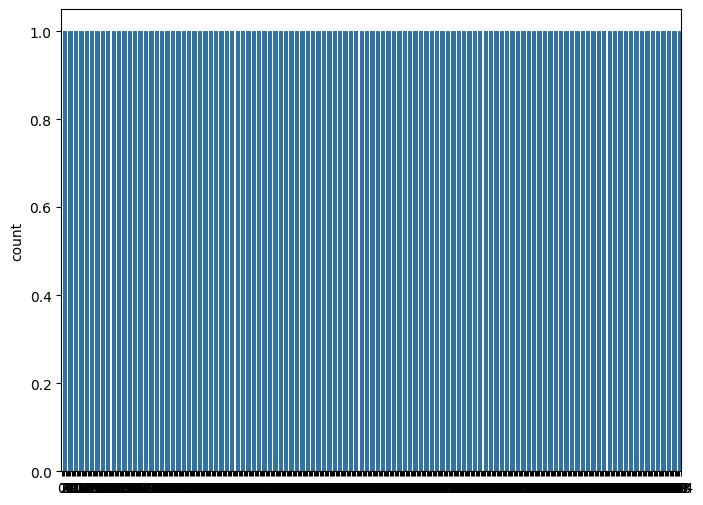

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(customer.Stars)
plt.show()

## Sentiment Analysis to find positive and negative reviews

In [10]:
X = customer['Reviews']
Y = customer['Stars']

In [11]:
X.head()

0    Great job, Wyndham Capital! Each person was pr...
1    Matthew Richardson is professional and helpful...
2    We had a past experience with Wyndham Mortgage...
3    We have been dealing with Brad Thomka from the...
4    I can't express how grateful I am for the supp...
Name: Reviews, dtype: object

In [12]:
# UDF to find sentiment polarity of the reviews
def sentiment_review(text):
    analysis = TextBlob(text)
    polarity_text = analysis.sentiment.polarity
    if polarity_text > 0:
        return 'Positive'
    elif polarity_text == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [13]:
# creating dictionary which will contain both the review and the sentiment of the review
final_dictionary = []
for text in X:
    dictionary_sentiment = {}
    dictionary_sentiment['Review'] = text
    dictionary_sentiment['Sentiment'] = sentiment_review(text)
    final_dictionary.append(dictionary_sentiment)
print(final_dictionary[:5])

[{'Review': 'Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!', 'Sentiment': 'Positive'}, {'Review': 'Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!', 'Sentiment': 'Positive'}, {'Review': 'We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind', 'Sentiment': 'Negative'}, {'Review': 'We have been dealing with Brad Thomka from the beginning of what started out to be a very stressful time for us, but 

In [14]:
# Finding positive reviews
positive_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Positive':
        positive_reviews.append(review)
print(positive_reviews[:5])


[{'Review': 'Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!', 'Sentiment': 'Positive'}, {'Review': 'Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!', 'Sentiment': 'Positive'}, {'Review': 'We have been dealing with Brad Thomka from the beginning of what started out to be a very stressful time for us, but with the help from Brad and the entire Wyndham Mortgage team it was turned into a happy ending!! Brad and Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled\xa0together and found a viable option for us that ultimately saved us money. We are indebted and would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & LindRead Less', 'Sentimen

In [15]:
# Finding neutral reviews
neutral_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Neutral':
        neutral_reviews.append(review)
print(neutral_reviews[:5])

[{'Review': '\r\nPerson with whom I spoke kept interrupting me and telling me his "line" rather than listening to what info I wanted. Quite pushy, altho\' he said he wasn\'t a salesman. Closing costs were astronomical.\r\n        ', 'Sentiment': 'Neutral'}, {'Review': '\r\nThe rate re-lock-in rule was not followed.\r\n        ', 'Sentiment': 'Neutral'}, {'Review': "\r\nLending tree matching me up with companies that don't offer the product I requested.\r\n        ", 'Sentiment': 'Neutral'}, {'Review': '\r\nThey called me and asked about the city in NH that we where looking at and when I told him we might consider MA as well he hung up on me.\r\n        ', 'Sentiment': 'Neutral'}]


In [16]:
# Finding negative reviews
negative_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Negative':
        negative_reviews.append(review)
print(negative_reviews[:5])

[{'Review': 'We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind', 'Sentiment': 'Negative'}, {'Review': 'This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The appraiser that they hired made so many mistakes I had to send in corrections and then during the underwriting process they had to go back and make more corrections. Wyndum would continue to ask for copies of documents over and over again. There were many documents that I had to send 3 a

In [17]:
# counting number of positive,neutral and negative reviews
reviews_count = pd.DataFrame([len(positive_reviews),len(neutral_reviews),len(negative_reviews)],index=['Positive','Neutral','Negative'])

In [18]:
reviews_count

,0
Positive,466
Neutral,4
Negative,35


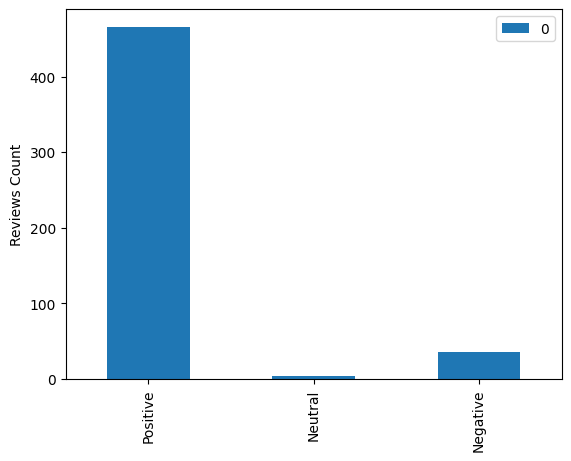

In [19]:
reviews_count.plot(kind='bar')
plt.ylabel('Reviews Count')
plt.show()

In [20]:
# printing first five positive reviews
i=1
for review in positive_reviews[:5]:
        print(i)
        print(review['Review'])
        print('******************************************************')
        i+=1

1
Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!
******************************************************
2
Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!
******************************************************
3
We have been dealing with Brad Thomka from the beginning of what started out to be a very stressful time for us, but with the help from Brad and the entire Wyndham Mortgage team it was turned into a happy ending!! Brad and Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We are indebted and would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & LindR

In [21]:
# printing first five negative reviews
i=1
for review in negative_reviews[:5]:
        print(i)
        print(review['Review'])
        print('******************************************************')
        i+=1

1
We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind
******************************************************
2
This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The appraiser that they hired made so many mistakes I had to send in corrections and then during the underwriting process they had to go back and make more corrections. Wyndum would continue to ask for copies of documents over and over again. There were many documents that I had to se

## Finding most frequently used Positive/ Negative words

### Data Preprocessing

In [22]:
# UDF to clean the reviews
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = "".join([char for char in text if char not in string.punctuation])
    return text

In [23]:
# X = customer['Reviews']
X.head()

0    Great job, Wyndham Capital! Each person was pr...
1    Matthew Richardson is professional and helpful...
2    We had a past experience with Wyndham Mortgage...
3    We have been dealing with Brad Thomka from the...
4    I can't express how grateful I am for the supp...
Name: Reviews, dtype: object

In [24]:
# applying clean_text function defined above to remove punctuation, strip extra spaces and convert each word to lowercase
X = X.apply(lambda y: clean_text(y))

In [25]:
X.head()

0    great job wyndham capital each person was prof...
1    matthew richardson is professional and helpful...
2    we had a past experience with wyndham mortgage...
3    we have been dealing with brad thomka from the...
4    i cant express how grateful i am for the suppo...
Name: Reviews, dtype: object

### Coverting reviews to tokens

In [26]:
tokens_vect = CountVectorizer(stop_words='english')

In [27]:
token_dtm = tokens_vect.fit_transform(X)

In [29]:
tokens_vect.get_feature_names()

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
print(type(tokens_vect))

<class 'sklearn.feature_extraction.text.CountVectorizer'>


In [32]:
feature_names = tokens_vect.get_feature_names_out()

In [33]:
token_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
token_dtm.toarray().shape

(505, 2507)

In [36]:
len(feature_names)

2507

In [38]:
pd.DataFrame(token_dtm.toarray(),columns = feature_names)

,10,100,101,1014,1031,1040s,11,12,13,15,...,xx,year,years,yelp,yep,yes,youi,zach,zelada,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
501,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
print(token_dtm)

  (0, 1022)	1
  (0, 1244)	1
  (0, 2495)	1
  (0, 365)	1
  (0, 1649)	1
  (0, 1739)	1
  (0, 1081)	1
  (0, 1857)	1
  (0, 1727)	1
  (0, 2092)	1
  (0, 2254)	1
  (1, 1739)	1
  (1, 1081)	1
  (1, 2254)	1
  (1, 1423)	2
  (1, 1945)	1
  (1, 1082)	1
  (1, 557)	1
  (1, 1736)	1
  (1, 1487)	1
  (1, 820)	1
  (1, 2037)	1
  (2, 2495)	4
  (2, 365)	1
  (2, 1487)	3
  :	:
  (504, 170)	1
  (504, 2298)	3
  (504, 200)	2
  (504, 1812)	1
  (504, 1827)	1
  (504, 528)	3
  (504, 48)	1
  (504, 929)	1
  (504, 24)	2
  (504, 30)	1
  (504, 55)	2
  (504, 1441)	2
  (504, 1115)	2
  (504, 812)	1
  (504, 239)	1
  (504, 2206)	1
  (504, 2230)	1
  (504, 2229)	2
  (504, 1287)	1
  (504, 829)	1
  (504, 844)	2
  (504, 50)	1
  (504, 1891)	2
  (504, 493)	1
  (504, 685)	1


In [41]:
# creating a dataframe which shows the count of how many times a word is coming in the corpus
count_dtm_dataframe = pd.DataFrame(np.sum(token_dtm.toarray(),axis=0),feature_names).reset_index()
count_dtm_dataframe.columns =['Word','Count']

In [42]:
count_dtm_dataframe.head()

,Word,Count
0,10,10
1,100,9
2,101,1
3,1014,1
4,1031,2


In [43]:
#adding sentiment column which shows sentiment polarity of each word
sentiment_word = []
for word in count_dtm_dataframe['Word']:
    sentiment_word.append(sentiment_review(word))
count_dtm_dataframe['Sentiment'] = sentiment_word

In [44]:
count_dtm_dataframe.head()

,Word,Count,Sentiment
0,10,10,Neutral
1,100,9,Neutral
2,101,1,Neutral
3,1014,1,Neutral
4,1031,2,Neutral


In [45]:
# separating positive words
positive_words_df= count_dtm_dataframe.loc[count_dtm_dataframe['Sentiment']=='Positive',:].sort_values('Count',ascending=False)

In [46]:
positive_words_df.head(20)

,Word,Count,Sentiment
1022,great,139,Positive
278,best,99,Positive
1739,professional,70,Positive
746,easy,65,Positive
1095,highly,64,Positive
2257,thanks,61,Positive
2207,sure,51,Positive
64,able,47,Positive
1008,good,39,Positive
1056,happy,37,Positive


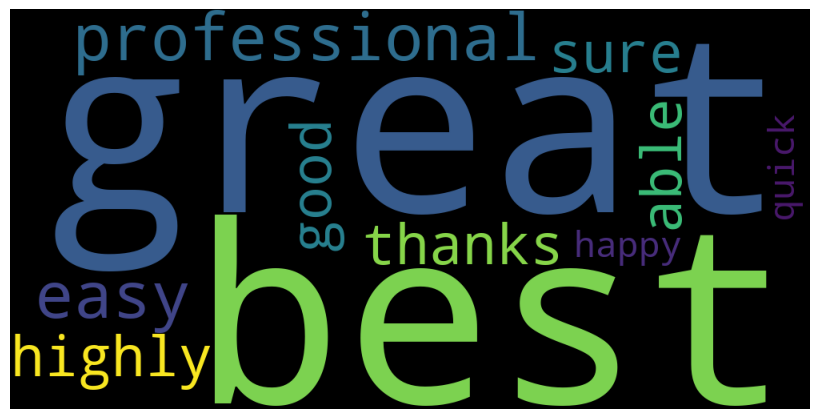

In [47]:
# plotting word cloud of 10 most frequently used positive words
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positive_words_df.iloc[0:11,0]))
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [48]:
# separating negative words
negative_words_df= count_dtm_dataframe.loc[count_dtm_dataframe['Sentiment']=='Negative',:].sort_values('Count',ascending=False)

In [49]:
negative_words_df.head(10)

,Word,Count,Sentiment
436,closed,68,Negative
858,extremely,46,Negative
1059,hard,40,Negative
1686,poor,32,Negative
489,complicated,18,Negative
1352,little,15,Negative
1715,previous,13,Negative
1619,past,13,Negative
829,expected,11,Negative
2127,spent,11,Negative


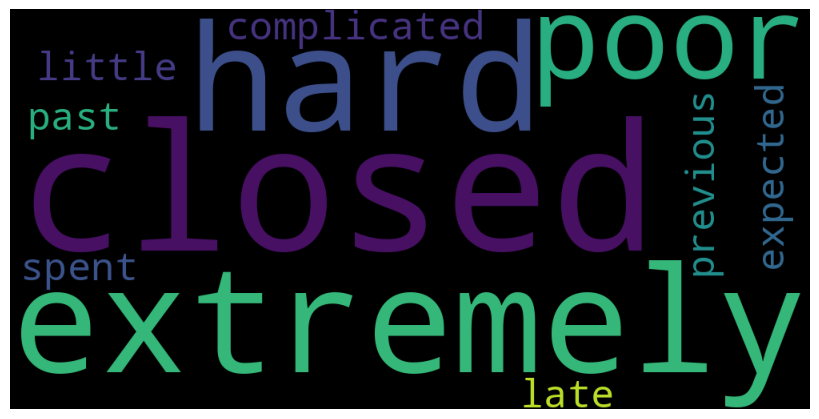

In [50]:
# plotting word cloud of 10 most frequently used positive words
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negative_words_df.iloc[0:11,0]))
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Topic Modelling

### Splitting the data into train and test

In [51]:
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,random_state = 123, test_size = 0.2)

In [52]:
print('No.of observations in train_X: ',len(train_X), '| No.of observations in test_X: ',len(test_X))
print('No.of observations in train_Y: ',len(train_Y), '| No.of observations in test_Y: ',len(test_Y))

No.of observations in train_X:  404 | No.of observations in test_X:  101
No.of observations in train_Y:  404 | No.of observations in test_Y:  101



# Feature Generation using DTM and TDM

### Feature generation using DTM

In [53]:
vect = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1),min_df=0.001,max_df=0.95)

In [54]:
train_X_fit = vect.fit(train_X)
train_X_dtm = vect.transform(train_X)
test_X_dtm = vect.transform(test_X)

In [55]:
print(train_X_dtm)

  (0, 31)	1
  (0, 406)	1
  (0, 569)	1
  (0, 892)	1
  (0, 922)	1
  (0, 937)	2
  (0, 946)	1
  (0, 1701)	1
  (0, 2004)	2
  (0, 2041)	1
  (0, 2101)	1
  (0, 2271)	1
  (0, 2298)	1
  (1, 406)	2
  (1, 530)	1
  (1, 630)	2
  (1, 1087)	1
  (1, 1097)	1
  (1, 1320)	1
  (1, 1375)	1
  (1, 1400)	1
  (1, 1657)	1
  (1, 1666)	1
  (1, 2120)	1
  (1, 2130)	1
  :	:
  (402, 1728)	1
  (402, 2130)	1
  (402, 2188)	1
  (402, 2298)	1
  (403, 254)	1
  (403, 337)	1
  (403, 721)	1
  (403, 772)	1
  (403, 824)	1
  (403, 827)	1
  (403, 952)	2
  (403, 1033)	1
  (403, 1233)	1
  (403, 1263)	1
  (403, 1439)	1
  (403, 1628)	1
  (403, 1666)	2
  (403, 1669)	1
  (403, 1686)	1
  (403, 1860)	1
  (403, 1889)	1
  (403, 1906)	1
  (403, 1978)	1
  (403, 2092)	1
  (403, 2293)	1


In [56]:
print(test_X_dtm)

  (0, 389)	1
  (0, 694)	1
  (0, 738)	1
  (0, 857)	1
  (0, 1263)	2
  (0, 1597)	2
  (0, 1651)	1
  (0, 1844)	1
  (0, 2299)	1
  (1, 65)	1
  (1, 210)	1
  (1, 236)	1
  (1, 261)	1
  (1, 316)	1
  (1, 411)	1
  (1, 596)	1
  (1, 621)	1
  (1, 655)	1
  (1, 688)	1
  (1, 752)	3
  (1, 811)	1
  (1, 846)	1
  (1, 853)	1
  (1, 999)	1
  (1, 1181)	1
  :	:
  (99, 2309)	1
  (100, 59)	1
  (100, 139)	1
  (100, 222)	1
  (100, 322)	1
  (100, 795)	1
  (100, 796)	1
  (100, 894)	1
  (100, 946)	1
  (100, 1000)	1
  (100, 1003)	1
  (100, 1027)	1
  (100, 1181)	1
  (100, 1349)	1
  (100, 1483)	1
  (100, 1564)	1
  (100, 1597)	1
  (100, 1650)	1
  (100, 1677)	1
  (100, 2063)	1
  (100, 2092)	1
  (100, 2101)	1
  (100, 2116)	1
  (100, 2236)	1
  (100, 2278)	1


In [57]:
vect.get_feature_names()

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
vect.get_feature_names_out()

array(['10', '100', '101', ..., 'zach', 'zelada', 'zero'], dtype=object)

In [61]:
print('No.of features for are',len(vect.get_feature_names_out()))

No.of features for are 2326


In [62]:
train_X_dtm_df = pd.DataFrame(train_X_dtm.toarray(),columns=vect.get_feature_names_out())

In [63]:
train_X_dtm_df.head()

,10,100,101,1014,1031,1040s,11,12,13,15,...,wyndum,xx,year,years,yelp,yep,yes,zach,zelada,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Finding how many times a tem is used in corpus
train_dtm_freq = np.sum(train_X_dtm_df,axis=0)

In [65]:
train_dtm_freq.head(20)

10       7
100      7
101      1
1014     1
1031     2
1040s    1
11       6
12       4
13       3
15       5
18       1
19th     1
1st      2
20       3
200      1
2005     1
2011     1
2017     1
20k      2
212      3
dtype: int64

### Feature generation using TDM

In [66]:
vect_tdm = TfidfVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1),min_df=0.001,max_df=0.95)

In [67]:
train_X_tdm = vect_tdm.fit_transform(train_X)
test_X_tdm = vect.transform(test_X)

In [68]:
print(train_X_tdm)

  (0, 2298)	0.14286983052671703
  (0, 946)	0.14224755314415755
  (0, 2271)	0.17571044807822656
  (0, 922)	0.3233491825918004
  (0, 892)	0.26011295239170645
  (0, 1701)	0.2512400242662845
  (0, 2041)	0.3233491825918004
  (0, 2101)	0.22021533325477322
  (0, 406)	0.1561851580910362
  (0, 569)	0.19081216066170623
  (0, 31)	0.26512133571501156
  (0, 937)	0.38453891230399817
  (0, 2004)	0.5110113727041861
  (1, 1320)	0.32157178350945675
  (1, 1097)	0.24221516698235504
  (1, 1400)	0.2144229039259181
  (1, 1375)	0.25868315281967424
  (1, 2130)	0.19906648114206718
  (1, 2120)	0.22944160479471662
  (1, 530)	0.25868315281967424
  (1, 630)	0.4479713951840844
  (1, 1657)	0.338039769346776
  (1, 1666)	0.1545477952469896
  (1, 1087)	0.3612500917730076
  (1, 406)	0.3106532661840388
  :	:
  (402, 1698)	0.1238490539966841
  (402, 1000)	0.19903961080263602
  (402, 2130)	0.19212465963127884
  (402, 2298)	0.13712974487668564
  (403, 1686)	0.2898920480946295
  (403, 337)	0.2898920480946295
  (403, 1906)	0.2

In [69]:
print(test_X_tdm)

  (0, 389)	1
  (0, 694)	1
  (0, 738)	1
  (0, 857)	1
  (0, 1263)	2
  (0, 1597)	2
  (0, 1651)	1
  (0, 1844)	1
  (0, 2299)	1
  (1, 65)	1
  (1, 210)	1
  (1, 236)	1
  (1, 261)	1
  (1, 316)	1
  (1, 411)	1
  (1, 596)	1
  (1, 621)	1
  (1, 655)	1
  (1, 688)	1
  (1, 752)	3
  (1, 811)	1
  (1, 846)	1
  (1, 853)	1
  (1, 999)	1
  (1, 1181)	1
  :	:
  (99, 2309)	1
  (100, 59)	1
  (100, 139)	1
  (100, 222)	1
  (100, 322)	1
  (100, 795)	1
  (100, 796)	1
  (100, 894)	1
  (100, 946)	1
  (100, 1000)	1
  (100, 1003)	1
  (100, 1027)	1
  (100, 1181)	1
  (100, 1349)	1
  (100, 1483)	1
  (100, 1564)	1
  (100, 1597)	1
  (100, 1650)	1
  (100, 1677)	1
  (100, 2063)	1
  (100, 2092)	1
  (100, 2101)	1
  (100, 2116)	1
  (100, 2236)	1
  (100, 2278)	1


In [70]:
vect_tdm.get_feature_names()

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
print(type(vect_tdm))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [73]:
feature_names = vect_tdm.vocabulary_

In [74]:
print('No.of features for are',len(feature_names))

No.of features for are 2326


In [75]:
# creating dataframe to to see which features are present in the documents
train_X_tdm_df = pd.DataFrame(train_X_tdm.toarray(),columns=feature_names)

In [76]:
train_X_tdm_df.head()

,steve,got,30,day,closing,things,supervisor,recommended,friend,glad,...,painting,switched,red,flags,settled,fairly,returning,wyndum,candid,reasonable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
test_X_tdm_df = pd.DataFrame(test_X_tdm.toarray(),columns=feature_names)

In [79]:
test_X_tdm_df.head()

,steve,got,30,day,closing,things,supervisor,recommended,friend,glad,...,painting,switched,red,flags,settled,fairly,returning,wyndum,candid,reasonable
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Finding how many times a term is used in test corpus
test_tdm_freq = np.sum(test_X_tdm_df,axis=0)

In [81]:
test_tdm_freq.head(20)

steve          3
got            2
30             0
day            0
closing        0
things         0
supervisor     0
recommended    2
friend         1
glad           0
went           0
great          0
work           0
increased      0
rate           0
quoted         0
different      0
costs          0
times          0
took           0
dtype: int64

In [83]:
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=50)
X_topics = lda_model.fit_transform(train_X_tdm)
topic_word = lda_model.components_
vocab = feature_names

In [84]:
# view the topic models
top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print(topic_words)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [85]:
topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_words+1):-1, None]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [86]:
print(np.argsort(topic_dist).shape)

(2326,)


In [87]:
print(np.array(vocab).shape)

()


In [88]:
try:
    topic_words = np.array(vocab)[np.argsort(topic_dist)]
except IndexError as e:
    print(e)

too many indices for array: array is 0-dimensional, but 1 were indexed


In [89]:
topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_words+1):-1, None]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [90]:
# view the topic models
top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
topic_summaries

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

# Building Model

### Building Model on DTM

In [91]:
# building naive bayes model on DTM
naive_model = MultinomialNB()
naive_model.fit(train_X_dtm,train_Y)

MultinomialNB()

In [92]:
predict_train = naive_model.predict(train_X_dtm)
predict_test = naive_model.predict(test_X_dtm)

In [93]:
len(predict_test)

101

In [94]:
print('Accuracy on train: ',metrics.accuracy_score(train_Y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_Y,predict_test))

Accuracy on train:  0.9900990099009901
Accuracy on test:  0.9801980198019802


In [95]:
# predict probabilities on train and test
predict_prob_train = naive_model.predict_proba(train_X_dtm)[:,1]
predict_prob_test = naive_model.predict_proba(test_X_dtm)[:,1]

In [96]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_Y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_Y,predict_prob_test))

ROC_AUC score on train:  0.9962667302116843
ROC_AUC score on test:  0.9866131191432396


In [99]:
cm_test = metrics.confusion_matrix(test_Y,predict_test)

In [101]:
cm_test

array([[17,  1],
       [ 1, 82]])

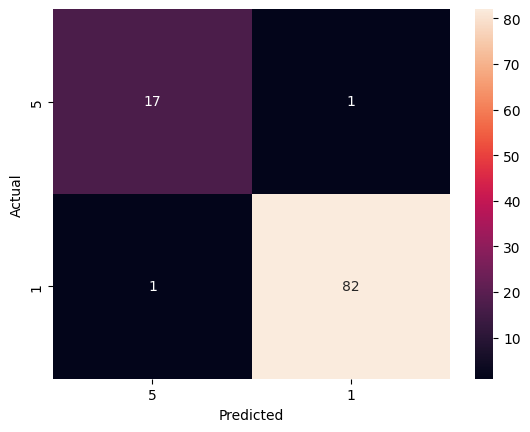

In [100]:
import seaborn as sns
sns.heatmap(cm_test,annot=True,xticklabels=[5,1],yticklabels=[5,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Building Model on TDM

In [102]:
# building naive bayes model on DTM
naive_model = MultinomialNB()
naive_model.fit(train_X_tdm,train_Y)

MultinomialNB()

In [103]:
predict_train = naive_model.predict(train_X_tdm)
predict_test = naive_model.predict(test_X_tdm)

In [104]:
len(predict_test)

101

In [105]:
print('Accuracy on train: ',metrics.accuracy_score(train_Y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_Y,predict_test))

Accuracy on train:  0.9306930693069307
Accuracy on test:  0.9207920792079208


In [106]:
# predict probabilities on train and test
predict_prob_train = naive_model.predict_proba(train_X_tdm)[:,1]
predict_prob_test = naive_model.predict_proba(test_X_tdm)[:,1]

In [107]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_Y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_Y,predict_prob_test))

ROC_AUC score on train:  0.9953135549465825
ROC_AUC score on test:  0.9832663989290495


In [109]:
# confusion matrix on test
cm_test = metrics.confusion_matrix(test_Y,predict_test)

In [110]:
cm_test

array([[11,  7],
       [ 1, 82]])

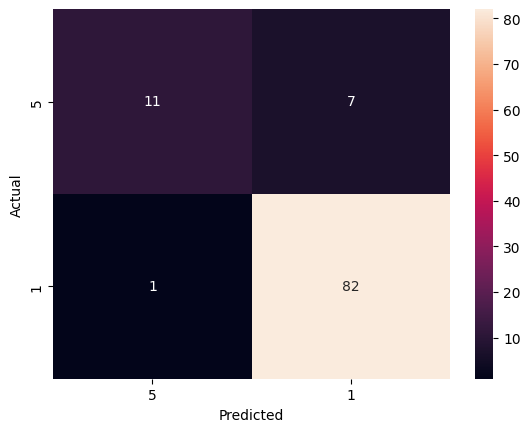

In [111]:
import seaborn as sns
sns.heatmap(cm_test,annot=True,xticklabels=[5,1],yticklabels=[5,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<h3> Model showed better results using DTM values and using unigrams.</h3>

## We were asked that we can ignore intent analysis as that is covered in topic modelling. Hence skipping that part.